# ODE for SEIR

# Setup

In [102]:
from pydantic import BaseModel, PositiveInt, model_validator, Field
from enum import Enum, Flag, auto
from pyvis.network import Network
import numpy as np
from numpy.typing import NDArray
import matplotlib.pyplot as plt
import networkx as nx
from typing import Any, Final
from collections import defaultdict
from itertools import combinations, product

### Constants

In [2]:
DISPLAY_WIDTH = 800
DISPLAY_HEIGHT = 800

DAY_IN_HOURS: Final[int] = 24

# Model

### Agent

In [263]:
class AgentState(Flag):
    S = auto()
    E = auto()
    I0 = auto()
    I1 = auto()
    I2 = auto()
    R = auto()
    H = auto()
    D = auto()

    INFECTIOUS = I0 | I1 | I2 | H
    IMMUNE = R | D | E

class AgentType(Enum):
    CHILD = auto()
    ADULT = auto()
    RETIRED = auto()


class Place(Flag):
    MISSING = auto()
    HOUSEHOLD = auto()
    HOSPITAL = auto()
    SCHOOL = auto()
    PRIMARY_CARE = auto()
    OTHER_WORKING_PLACE = auto()
    PUBLIC_PLACE = auto()

    ADULT_WORKSPACE = HOSPITAL | SCHOOL | PRIMARY_CARE | OTHER_WORKING_PLACE | PUBLIC_PLACE
    FREE_TIME = HOUSEHOLD | PRIMARY_CARE | PUBLIC_PLACE

class AgentCurrentState(BaseModel):
    location_id: int
    arrived_at: int
    stay_until: int

    @model_validator(mode="after")
    def check_valid_visit_time(self):
        if self.arrived_at > self.stay_until:
            raise ValueError("Arrived is consequtive for exiting time.")
        return self

MISSING_STATE = AgentCurrentState(location_id=-1, arrived_at=-1, stay_until=-1)

class Agent:
    agents: list["Agent"] = []

    @staticmethod
    def reset() -> None:
        Agent.agents = []

    def __init__(self, state: AgentState, type: AgentType) -> None:
        self._id = len(Agent.agents)
        self._state = state
        self.current = MISSING_STATE
        self.house_id: int | None = None
        self.work_id: int | None = None
        self._travel_destinations: list[int] = []
        self._type = type
        Agent.agents.append(self)
    
    @property
    def location(self) -> "Location":
        if self.current == MISSING_STATE:
            msg = f"Location is missing for agent {self._id}"
            raise RuntimeError(msg)
        return Location.location[self.current.location_id]

    @property
    def type(self) -> AgentType:
        return self._type

    @property
    def house(self) -> "Location":
        if self.house_id is None:
            msg = f"House is missing for agent {self._id}"
            raise RuntimeError(msg)
        return Location.location[self.house_id]

    def add_travel_destination(self, dest_id: int | list[int]| NDArray[np.int64]) -> None:
        if self.house_id is None or (self.work_id is None and self._type != AgentType.RETIRED):
            msg = f"Agent {self._id} is not completely initialized. Adding travel destinations is disabled."
            raise RuntimeError(msg)
        if isinstance(dest_id, int):
            self._travel_destinations.append(dest_id)
        elif isinstance(dest_id, np.ndarray):
            self._travel_destinations.extend(dest_id.tolist())
        elif isinstance(dest_id, list):
            self._travel_destinations.extend(dest_id)
        else:
            msg = f"Invalid dest_id type: {type(dest_id)}."
            raise TypeError(msg)


### Location

In [264]:

class Location:
    locations: list["Location"] = []

    @staticmethod
    def reset() -> None:
        Location.locations = []

    @staticmethod
    def get_ids(type: Place) -> list[int]:
        return [i._id for i in Location.locations if i._type == type]

    def __init__(self, type: Place, size: int | None = None) -> None:
        self._id = len(Location.locations)
        self.max_size = size
        self.slots: list[Agent] = []
        self._type = type
        Location.locations.append(self)
    
    @property
    def id(self) -> int:
        return self._id
    
    @property
    def type(self) -> Place:
        return self._type
    
    def add_agent(self, agent: Agent):
        if len(self.slots) == self.max_size:
            msg = f"Reached slots limit in location {self._id}."
            raise RuntimeError(msg)
        self.slots.append(agent)
    
    def remove_agent(self, agent: Agent):
        try:
            self.slots.remove(agent)
        except:
            msg = f"Cannot remove non-existing agent from location {self._id}"
            raise RuntimeError(msg)

### Networks

In [265]:
class WorldParams(BaseModel):
    N: PositiveInt
    schools: PositiveInt
    primary_care: PositiveInt
    hospitals: PositiveInt
    other_working_places: PositiveInt
    public_places: PositiveInt

class NodesColors(Enum):
    HOUSEHOLD = "gray"
    SCHOOL = "brown"
    PRIMARY_CARE = "orange"
    HOSPITAL = "red"
    OTHER_WORKING_PLACE = "cyan"
    PUBLIC_PLACE = "green"

class World:
    def __init__(self, params: WorldParams, seed: int | None = None) -> None:
        self.params = params
        self.seed = seed
        self.households_capacities: NDArray[np.int64] | None = None
        self.reset()

        self.households_ids: list[int] = []
        self.agents_households_assignments: dict[int, int] = {}
    
    def init(self) -> None:
        self.reset()
        self._add_places()
        network: dict[str, Any] = self._create_friendship_network()
        self._add_befriend_households_links(network)

    
    def reset(self) -> None:
        Location.reset()
        self.rng = np.random.default_rng(self.seed)
        self._g = nx.Graph()
        self._get_household_sizes()
        
    def _add_places(self) -> nx.Graph:
        households = [Location(Place.HOUSEHOLD) for _ in range(len(self.households_capacities))]
        public = []
        for (type_, N) in [
            (Place.HOSPITAL, self.params.hospitals),
            (Place.SCHOOL, self.params.schools),
            (Place.PRIMARY_CARE, self.params.primary_care),
            (Place.OTHER_WORKING_PLACE, self.params.other_working_places),
            (Place.PUBLIC_PLACE, self.params.public_places),
        ]:
            locations = [Location(type_) for _ in range(N)]
            public.extend(locations)
        self.households_ids = [h.id for h in households]
        public_ids = [p.id for p in public]
        self._g.add_nodes_from(self.households_ids + public_ids) #TODO: use objects instead integers
        self._g.add_edges_from(combinations(public_ids, 2))
        self._g.add_edges_from(product(public_ids, self.households_ids))
    
    def __call__(self) -> nx.Graph:
        return self._g
    
    def _create_friendship_network(self) -> None:
        p_rewire = 0.55
        G_people = nx.relaxed_caveman_graph(
            l=len(self.households_capacities),
            k=self.households_capacities.max(),
            p=p_rewire,
            seed=self.seed,
        )
        total_generated_nodes = len(G_people.nodes.keys())
        to_remove = np.max(total_generated_nodes - self.households_capacities.sum(), 0)
        nodes_to_remove = self.rng.choice(np.arange(total_generated_nodes), size=to_remove, replace=False)
        G_people.remove_nodes_from(nodes_to_remove)
        G_people = nx.relabel_nodes(G_people, mapping={prev: new for prev, new in zip(G_people.nodes.keys(), range(self.params.N))})
        min_degree = 7
        #potential improvement: now we guarantee min 7 degree at person level, so each house may have much more
        # connections than 7. We can integrate this enforcement at the household level but this is a bit more complex
        enforce_min_degree(G_people, min_degree, self.rng)
        
        person_to_household = {}
        current = 0
        for household_id, size in zip(self.households_ids, self.households_capacities):
            members = list(G_people.nodes)[current : current + size]
            for m in members:
                person_to_household[m] = household_id
            current += size
        self.agents_households_assignments = person_to_household
        return {"relations": G_people, "house_assign": person_to_household}

    def _get_household_sizes(self) -> None:
        p = [0.1, 0.3, 0.5, 0.05, 0.03, 0.02]
        size_range = np.arange(1, 6 + 1)
        sizes = []
        total = 0
        while total < self.params.N:
            s = self.rng.choice(size_range, p=p)
            sizes.append(s)
            total += s
        sizes = np.array(sizes)
        excess = total - self.params.N
        if excess > 0:
            sizes[-1] -= excess
            if sizes[-1] == 0:
                sizes = sizes[:-1]
        self.households_capacities = sizes
        
    def _add_befriend_households_links(self, network_details) -> None:
        G_people = network_details["relations"]
        p2h = network_details["house_assign"]
        household_edges = set()
        for u, v in G_people.edges:
            hu, hv = p2h[u], p2h[v]
            if hu == hv:
                continue
            key = tuple(sorted((hu, hv)))
            household_edges.add(key)
        for hu, hv in household_edges:
            self._g.add_edge(hu, hv)
    
    def draw(self) -> None:
        pos = nx.spring_layout(self._g, seed=self.seed)
        nx.draw_networkx_edges(self._g, pos)
        options = {"edgecolors": "tab:gray", "node_size": 100, "alpha": 0.9}
        for place in Place:
            if place == Place.MISSING:
                continue
            nx.draw_networkx_nodes(self._g, pos, nodelist=Location.get_ids(place), node_color=f"tab:{NodesColors[place.name].value}", **options)


In [266]:
def enforce_min_degree(G: nx.Graph, min_degree: int, rng) -> None:
    nodes = list(G.nodes)
    for u in nodes:
        while G.degree(u) < min_degree:
            candidates = [
                v for v in nodes
                if v != u and not G.has_edge(u, v)
            ]
            if not candidates:
                raise RuntimeError(
                    f"Cannot enforce min_degree={min_degree} for node {u}"
                )
            v = rng.choice(candidates)
            G.add_edge(u, v)

In [267]:
example_params = WorldParams(
    N=34,
    schools=1,
    primary_care=1,
    hospitals=1,
    other_working_places=1,
    public_places=1,
)

DegreeView({0: 15, 1: 15, 2: 13, 3: 15, 4: 12, 5: 14, 6: 15, 7: 15, 8: 14, 9: 12, 10: 14, 11: 12, 12: 16, 13: 16, 14: 16, 15: 16, 16: 16})

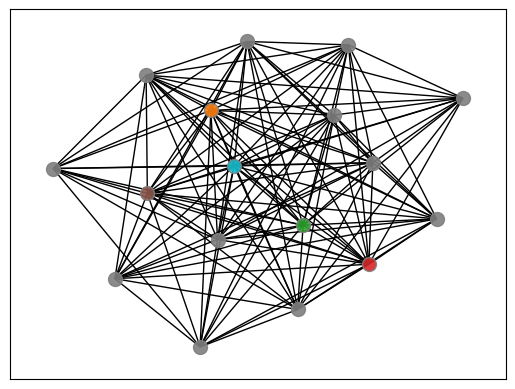

In [268]:
w = World(example_params, seed=1)
w.init()
w.draw()
w().degree()

### Simulation

In [269]:
class AgentTypeRatio(BaseModel):
    retired: float = Field(..., ge=0.0, le=1.0)
    adult: float = Field(..., ge=0.0, le=1.0)
    child: float = Field(..., ge=0.0, le=1.0)

    @model_validator(mode="after")
    def check_sum_is_one(self):
        if not abs(self.retired + self.adult + self.child - 1.0) < 1e-9:
            raise ValueError("Sum of retired, adult, and child must be 1.0")
        return self

class Params(BaseModel):
    T: PositiveInt
    N: PositiveInt
    exposed: float | PositiveInt
    ratios: AgentTypeRatio
    schools: PositiveInt
    primary_care: PositiveInt
    hospitals: PositiveInt
    other_working_places: PositiveInt
    public_places: PositiveInt

class Simulation:
    def __init__(self, params: Params, seed: int | None = None) -> None:
        self.seed = seed
        self.rng = np.random.default_rng(seed)
        self.params = params
        self.world_params = WorldParams(
            N=self.params.N,
            schools=self.params.schools,
            primary_care=self.params.primary_care,
            hospitals=self.params.hospitals,
            other_working_places=self.params.other_working_places,
            public_places=self.params.public_places,
        )
        
        self.world = World(self.world_params, seed)

    def init(self):
        self.reset()
        self.world.init()
        self._init_agents()
    
    def reset(self):
        Agent.reset()
        self.world.reset()
        self.rng = np.random.default_rng(self.seed)

    def _init_agents(self) -> None:
        agents: list[Agent] = []
        for type_, ratio in [
            (AgentType.ADULT, self.params.ratios.adult),
            (AgentType.CHILD, self.params.ratios.child),
            (AgentType.RETIRED, self.params.ratios.retired),
        ]:
            total = int(self.params.N * ratio)
            agents.extend([Agent(state=AgentState.S, type=type_) for _ in range(total)])
        if (missing:=self.params.N - len(agents)) > 0:
            agents.extend([Agent(state=AgentState.S, type=AgentType.ADULT) for _ in range(missing)])
        self._init_exposed_agents()
        self._assign_agents_to_households()
        self._assign_agents_to_workspace()
        self._assign_travel_destinations_for_agents()
            
    
    def _init_exposed_agents(self):
        total_exposed = (
            self.params.exposed if isinstance(self.params.exposed, int) else int(self.params.N * self.params.exposed)
        )
        exposed_ids = self.rng.choice(range(self.params.N), size=total_exposed, replace=False)
        for idx in exposed_ids:
            Agent.agents[idx]._state = AgentState.E
    
    def _assign_agents_to_households(self) -> None:
        for a_id, h_id in self.world.agents_households_assignments.items():
            Agent.agents[a_id].house_id = h_id
    
    def _assign_agents_to_workspace(self) -> None:
        schools_ids = [l._id for l in Location.locations if l.type == Place.SCHOOL]
        kids = [a for a in Agent.agents if a.type == AgentType.CHILD]
        kid_school_assignment = self.rng.choice(schools_ids, size=len(kids))
        for kid, school_id in zip(kids, kid_school_assignment):
            kid.work_id = school_id

        workspaces_ids = [l._id for l in Location.locations if l.type in Place.ADULT_WORKSPACE]
        adults = [a for a in Agent.agents if a.type == AgentType.ADULT]
        adult_work_assignment = self.rng.choice(workspaces_ids, size=len(adults))
        for adult, work_id in zip(adults, adult_work_assignment):
            adult.work_id = work_id
    
    def _assign_travel_destinations_for_agents(self) -> None:
        city = self.world()
        public_places_no = 5
        primary_care_no = 3
        households_no = 4
        public_places_id: list[int] = [l._id for l in Location.locations if l.type == Place.PUBLIC_PLACE]
        primary_care_id: list[int] = [l._id for l in Location.locations if l.type == Place.PRIMARY_CARE]
        for agent in Agent.agents:
            agent.add_travel_destination(int(agent.house_id))
            if agent.type != AgentType.RETIRED:
                agent.add_travel_destination(int(agent.work_id))
            selected_primary_care_id = self.rng.choice(primary_care_id, size=primary_care_no, replace=False)
            agent.add_travel_destination(selected_primary_care_id)
            selected_public_places_id = self.rng.choice(public_places_id, size=public_places_no, replace=False)
            agent.add_travel_destination(selected_public_places_id)
            households_id = [i for i in city.neighbors(agent.house_id) if Location.locations[i].type == Place.HOUSEHOLD]
            selected_households_id = self.rng.choice(households_id, size=households_no, replace=False)
            agent.add_travel_destination(selected_households_id)

    def _evaluate_step(self): ... #TODO: prepare simulation step

In [270]:
example_params = Params(
    T=10,
    N=51,
    exposed=0.01,
    ratios=AgentTypeRatio(retired=0.2, adult=0.6, child=0.2),
    schools=1,
    primary_care=5,
    hospitals=1,
    other_working_places=2,
    public_places=6,
)

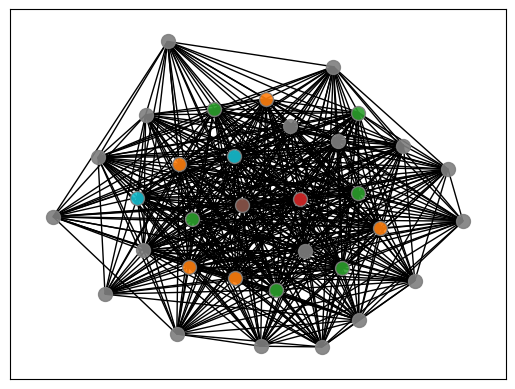

In [271]:
model = Simulation(params=example_params)
model.init()
model.world.draw()


In [ ]:
def get_html_graph_viz(graph, filename: str) -> None:
    g = Network(height=DISPLAY_HEIGHT, width=DISPLAY_WIDTH)
    g.toggle_hide_edges_on_drag(True)
    g.barnes_hut()
    g.from_nx(graph, default_node_size=50)
    g.save_graph(filename)

# Data applied for params